In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
import sys

warnings.filterwarnings('ignore')
from tensorflow import logging
logging.set_verbosity(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [2]:
sys.path.append('..')
from pydens import Solver, NumpySampler, cart_prod

from pydens import add_tokens
add_tokens()

<tr>
<td> <img src="params_1.png" alt="Drawing" style="width: 500px; height: 550px"/> </td>
<td> <img src="params_2.png" alt="Drawing" style="width: 500px; height: 200px"/> </td>
</tr>

In [3]:
m = (0.1 + 0.3) / 2
g = 9.81

k_o = (0.1 + 10) / 2
mu_o = (0.5 + 1) / 2
b_o = (1.1 + 1.5) / 2
rho_o = (750 + 950) / 2
coeff_o = k_o / (mu_o*b_o)
Q_o = 10 #(10 + 500) / 2

k_w = (0.1 + 10) / 2
mu_w = (0.2 + 12) / 2
b_w = (1.0 + 1.02) / 2
rho_w = (980 + 1040) / 2
coeff_w = k_w / (mu_w*b_w)
Q_w = 10 #(10 + 500) / 2

theta = (0.01 + 0.03) / 2
a = (-0.25 - 0.05) / 2
c = (-2 - 4) / 2

<img src="equations.png" alt="Drawing" style="width: 400px; height: 150px"/>

In [4]:
p_ow = lambda s_w: (2*theta / np.sqrt(k_o/m)) / (a*(1 - s_w)/(1 + c*s_w))

eq_1 = lambda p_w, s_w, x, y, z, t: div(coeff_o*D(p_w + p_ow(s_w)) - np.array([0, 0, rho_o*g, 0]), length=3) - \
                                    ((m / b_o)*D(1 - s_w, t) + Q_o)

eq_2 = lambda p_w, s_w, x, y, z, t: div(coeff_w*D(p_w) - np.array([0, 0, rho_w*g, 0]), length=3) - \
                                    ((m / b_w)*D(s_w, t) + Q_w)

In [5]:
initial_condition = [[200], [0.7]]

In [6]:
pde = {'n_dims': 4, 'n_funs': 2, 'n_eqns': 2,
       'form': [eq_1,
                eq_2],
       'initial_condition': initial_condition,
       'time_multiplier': 'sigmoid'}

# Put it all together in model-config
config = {
    'pde': pde,
#     'body': {'layout': 'fa fa fa RRfa+ fa fa+',
#              'units': [16, 32, 64, 64, 128, 64],
#              'activation': tf.nn.tanh},
#     'head': {'layout': 'fa f', 'units': [32, 1],
#              'activation': tf.nn.tanh},
    'decay': {'name': 'invtime', 'learning_rate':0.05,
              'decay_steps': 100, 'decay_rate': 0.05},
    'track': {'p_w': lambda p_w, s_w, x, y, z, t: p_w,
              'p_o': lambda p_w, s_w, x, y, z, t: p_w + p_ow(s_w),
              's_w': lambda p_w, s_w, x, y, z, t: s_w,
              's_o': lambda p_w, s_w, x, y, z, t: 1 - s_w},
}  

# Uniform sampling scheme
s = NumpySampler('u', dim=4)

In [7]:
# train the network on batches of 100 points
dg = Solver(config, layer_size=35)
dg.fit(batch_size=500, sampler=s, n_iters=1500, bar='notebook')

In [8]:
dg.fit(batch_size=1000, sampler=s, n_iters=10000, bar='notebook')

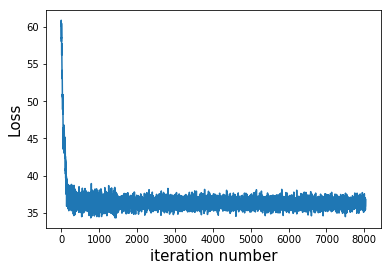

In [9]:
# Plot loss
plt.plot(dg.loss[50:])
plt.xlabel('iteration number', fontdict={'fontsize': 15})
plt.ylabel('Loss', fontdict={'fontsize': 15})
plt.show()

In [ ]:
# Plot one vertical trace
n_el = 100
pts_ = np.linspace(0, 1, n_el).reshape((n_el, 1))
pts = np.asarray([[0.5, 0.5, point, 0.01] for point in pts_])

approxs_p_w, approxs_p_o, approxs_s_w, approxs_s_o = dg.solve(pts, ['p_w', 'p_o', 's_w', 's_o'])
# approxs_s_w = dg.solve(pts, 's_w')

# approxs_p_o = dg.solve(pts, 'p_o')
# approxs_s_o = dg.solve(pts, 's_o')

fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(pts_, approxs_p_w.reshape(n_el, ), 'y', label='p_w approximation')
plt.plot(pts_, approxs_p_o.reshape(n_el, ), 'r', label='p_o approximation')

plt.legend(loc='auto', shadow=True, ncol=2)
fig.show()


fig, ax = plt.subplots(figsize=(6, 4))

plt.plot(pts_, approxs_s_w.reshape(n_el, ), 'y', label='s_w approximation')
plt.plot(pts_, approxs_s_o.reshape(n_el, ), 'r', label='s_o approximation')

plt.legend(loc='auto', shadow=True, ncol=2)
fig.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact
import ipyvolume

In [ ]:
# %matplotlib notebook

x = np.arange(0, 1, 0.1)
y = np.arange(0, 1, 0.1)
z = np.arange(0, 1, 0.1)
xx, yy, zz = np.meshgrid(x, y, z)

stacked = np.vstack([xx.flatten(), yy.flatten(), zz.flatten()]).T


def plt_solution(time):
    pts = np.hstack([stacked, time * np.ones((stacked.shape[0], 1))])
    
#     approxs_p_w = dg.solve(pts)[:, 0]
    approxs = np.array(dg.solve(pts, 's_o')).reshape(stacked.shape[0])
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    img = ax.scatter(xx.flatten(), yy.flatten(), zz.flatten(), c=approxs)
    fig.colorbar(img)
    print(np.mean(approxs))
    plt.show()

#     plt.xlabel(r'$t$', fontdict={'fontsize': 14})
#     plt.title(r'$\epsilon={}$'.format(e))
#     plt.legend()
    plt.show()

In [ ]:
_ = interact(plt_solution, time=(0, 1, 0.1))

In [ ]:
# %matplotlib notebook

x = np.arange(0, 1, 0.1)
y = np.arange(0, 1, 0.1)
xx, yy = np.meshgrid(x, y)

stacked = np.vstack([xx.flatten(), yy.flatten()]).T


def plt_solution(time):
    z = 0.5
    print(time)
    pts = np.hstack([stacked,
                     z * np.ones((stacked.shape[0], 1)),
                     time * np.ones((stacked.shape[0], 1))])
    
    print(pts[:, -1])
    
    approxs = np.array(dg.solve(pts, 's_w')).reshape(stacked.shape[0])
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    img = ax.imshow(approxs.reshape(10, 10))
    fig.colorbar(img)
    print(np.mean(approxs))
    plt.show()

#     plt.xlabel(r'$t$', fontdict={'fontsize': 14})
#     plt.title(r'$\epsilon={}$'.format(e))
#     plt.legend()
    plt.show()

In [ ]:
_ = interact(plt_solution, time=(0, 1, 0.1))

In [ ]:
pts